In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load Data

In [2]:
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# train_csv = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
# test_csv = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

# print('Train Size = {}'.format(len(train_csv)))
# print('Public Test Size = {}'.format(len(test_csv)))

def load_data():
    train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
    
    train_dir = os.path.join('../input/aptos2019-blindness-detection/','train_images/')
    test_dir = os.path.join('../input/aptos2019-blindness-detection/','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [3]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,../input/aptos2019-blindness-detection/train_i...,000c1434d8d7.png
1,001639a390f0,4,../input/aptos2019-blindness-detection/train_i...,001639a390f0.png
2,0024cdab0c1e,1,../input/aptos2019-blindness-detection/train_i...,0024cdab0c1e.png
3,002c21358ce6,0,../input/aptos2019-blindness-detection/train_i...,002c21358ce6.png
4,005b95c28852,0,../input/aptos2019-blindness-detection/train_i...,005b95c28852.png
5,0083ee8054ee,4,../input/aptos2019-blindness-detection/train_i...,0083ee8054ee.png


In [4]:
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "bright")
    plt.title('Distribution of Diabetic Retinography cases')
    plt.ylabel('Number of occurrences')
    plt.xlabel('Types of cases')
    plt.show() 

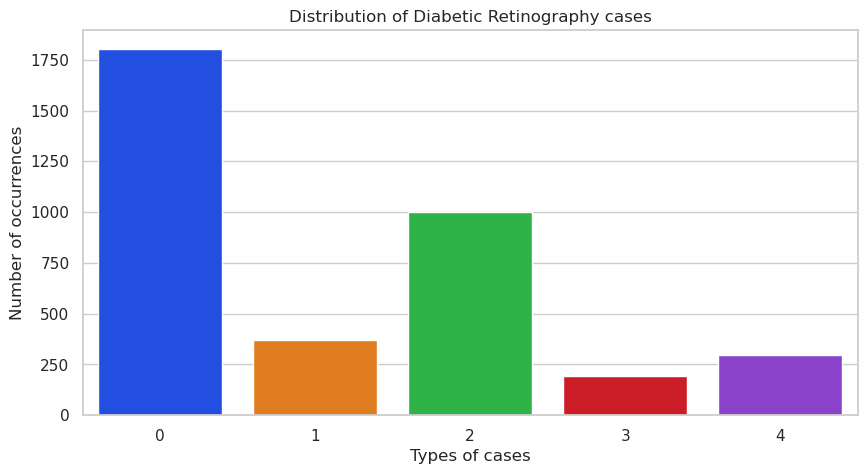

In [5]:
plot_classes(df_train)

# Visualise eye images

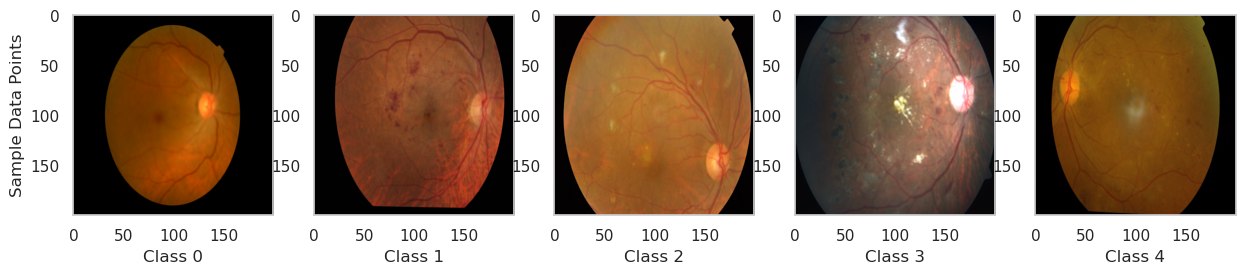

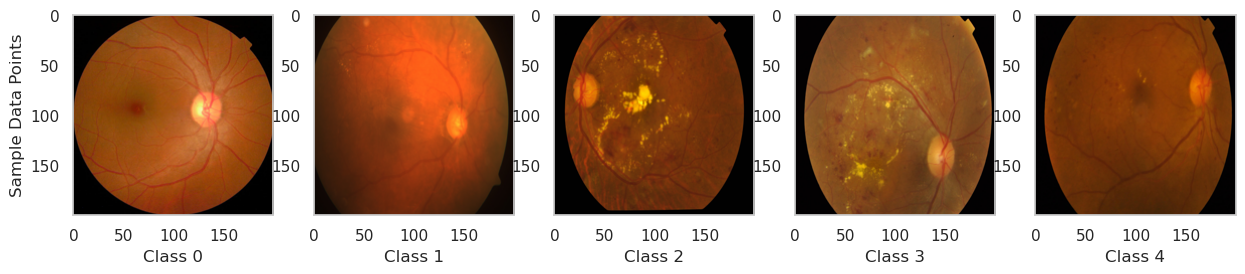

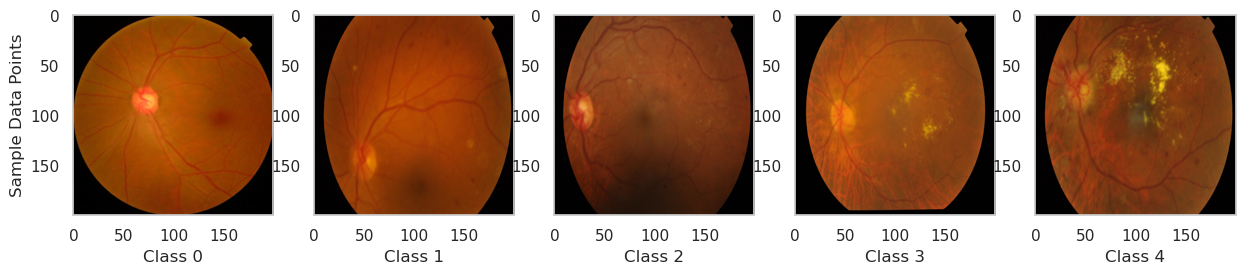

In [6]:
import cv2
from PIL import Image

IMG_SIZE = 200
def visualise_img(df, pts_per_class, color_scale):
    df = df.groupby('diagnosis',group_keys=False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop=True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = cv2.imread(df_temp.file_path.iloc[i])
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                axarr[i].imshow(img_gray,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

visualise_img(df_train,3,None)

# Image Processing
To bring out the distinctive features in the images, two methods will be used. Circular cropping & making the image grayscale as well as Gaussian Blur from OpenCV

In [7]:
from sklearn.model_selection import train_test_split
import os
import cv2
import multiprocessing
from multiprocessing.pool import ThreadPool

df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_test.shape)

(2929, 4) (733, 4)


Resize and save the train validation set of images

In [8]:
IMG_SIZE = 512

def image_resize_save(file):
    input_filepath = os.path.join('../input/aptos2019-blindness-detection/','train_images/','{}.png'.format(file))
    output_folder = '/kaggle/working/train_test_images_resized'
    os.makedirs(output_folder, exist_ok=True)
    output_filepath = os.path.join('/kaggle/working/','train_test_images_resized/','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

def multiprocess_save(process:int, img_list:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, img_list)
    return results

In [ ]:
multiprocess_save(6, list(df_train_test.id_code.values))

In [10]:
def crop_out_dark_components(img, tol=7):
    if img.ndim == 2:
        matrix = img > tol
        return img[np.ix_(matrix.any(1),matrix.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        matrix = gray_img > tol
        
        img_check = img[:,:,0][np.ix_(matrix.any(1),matrix.any(0))].shape[0]
        if img_check == 0:
            return img  # return the original img if the image after cropping is completely dark
        else:
            channel1 = img[:,:,0][np.ix_(matrix.any(1),matrix.any(0))]
            channel2 = img[:,:,1][np.ix_(matrix.any(1),matrix.any(0))]
            channel3 = img[:,:,2][np.ix_(matrix.any(1),matrix.any(0))]
            return np.stack([channel1, channel2, channel3], axis=-1)

def circular_crop(img, sigmaX=30):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_out_dark_components(img)
    
    height, width, depth = img.shape
    x = int(width/2)
    y = int(height/2)
    radius = np.amin((x,y)) # radius is set to be the minimum of width and x and y
                     
    circle = np.zeros((height, width), np.uint8)
    cv2.circle(circle,(x,y),radius,1,thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle)
    img = crop_out_dark_components(img)
    img=cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),sigmaX),-4,128)
    return img

In [11]:
def preprocess_image(file):
    input_filepath = os.path.join('/kaggle/working/','train_test_images_resized/','{}.png'.format(file))
    output_folder = '/kaggle/working/train_test_images_resized_preprocessed'
    os.makedirs(output_folder, exist_ok=True)
    output_filepath = os.path.join('/kaggle/working/','train_test_images_resized_preprocessed','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    img = circular_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
    
def multiprocess_image_processor(process:int, img_list:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, img_list)
    return results

Process the train validation set of images and save them in a new folder


In [ ]:
multiprocess_image_processor(6, list(df_train_test.id_code.values)) 

Now, do the same for the training set and create new folders for them

In [13]:
IMG_SIZE = 512

def image_resize_save(file):
    input_filepath = os.path.join('../input/aptos2019-blindness-detection/','train_images/','{}.png'.format(file))
    output_folder = '/kaggle/working/train_images_resized'
    os.makedirs(output_folder, exist_ok=True)
    output_filepath = os.path.join('/kaggle/working/','train_images_resized/','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

def multiprocess_save(process:int, img_list:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, img_list)
    return results

In [ ]:
multiprocess_save(6, list(df_train_train.id_code.values))

In [15]:
def preprocess_image(file):
    input_filepath = os.path.join('/kaggle/working/','train_images_resized/','{}.png'.format(file))
    output_folder = '/kaggle/working/train_images_resized_preprocessed'
    os.makedirs(output_folder, exist_ok=True)
    output_filepath = os.path.join('/kaggle/working/','train_images_resized_preprocessed','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    img = circular_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
    
def multiprocess_image_processor(process:int, img_list:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, img_list)
    return results

In [ ]:
multiprocess_image_processor(6, list(df_train_train.id_code.values)) 

# Train Model
Develop a CNN deep learning model using Tensorflow

In [31]:
# !pip install -U tensorflow
import tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras import optimizers, Model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=6,
                                                      class_mode="categorical",
                                                      target_size=(320, 320),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=6,
                                                      class_mode="categorical",    
                                                      target_size=(320, 320),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "./train_test_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(320, 320),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [19]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [41]:
# model = Sequential()
# model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=[320,320,3]))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(512,activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(df_train_train['diagnosis'].nunique(),activation='softmax')) #last Dense layer must match with the number of classes which is 5 in this case

# model.summary()

input_tensor = Input(shape=(320,320,3))
base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)
# base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(2048,activation='relu')(x)
x = Dropout(0.5)(x)
final_output = Dense(df_train_train['diagnosis'].nunique(),activation='softmax')(x)
model = Model(input_tensor, final_output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [42]:
model.compile(
optimizer = optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.CategoricalCrossentropy(),metrics = ['accuracy'])  
# Focal loss does a better job in handling class imbalance as is the case here in our task

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

390 97


In [44]:
history_pretraining = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,epochs=2,verbose=1).history

Epoch 1/2
390/390 [==============================] - 70s 164ms/step - loss: 0.8810 - accuracy: 0.6946 - val_loss: 1.3944 - val_accuracy: 0.2990
Epoch 2/2
390/390 [==============================] - 68s 175ms/step - loss: 0.6480 - accuracy: 0.7639 - val_loss: 1.0273 - val_accuracy: 0.5739


In [45]:
for layer in model.layers:
    layer.trainable = True

model.compile(
optimizer = optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])  

history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,epochs=10, callbacks=callback_list,verbose=1).history

Epoch 1/10
390/390 [==============================] - 77s 179ms/step - loss: 0.2185 - accuracy: 0.7784 - val_loss: 0.2946 - val_accuracy: 0.7079 - lr: 1.0000e-04
Epoch 2/10
390/390 [==============================] - 68s 175ms/step - loss: 0.1800 - accuracy: 0.8165 - val_loss: 0.1997 - val_accuracy: 0.7887 - lr: 1.0000e-04
Epoch 3/10
390/390 [==============================] - 68s 174ms/step - loss: 0.1565 - accuracy: 0.8353 - val_loss: 0.3144 - val_accuracy: 0.7251 - lr: 1.0000e-04
Epoch 4/10
390/390 [==============================] - 68s 174ms/step - loss: 0.1412 - accuracy: 0.8593 - val_loss: 0.2343 - val_accuracy: 0.7526 - lr: 1.0000e-04
Epoch 5/10
390/390 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.8755
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
390/390 [==============================] - 68s 174ms/step - loss: 0.1261 - accuracy: 0.8755 - val_loss: 0.2988 - val_accuracy: 0.7646 - lr: 1.0000e-04
Epoch 6/10
390/390 [=========

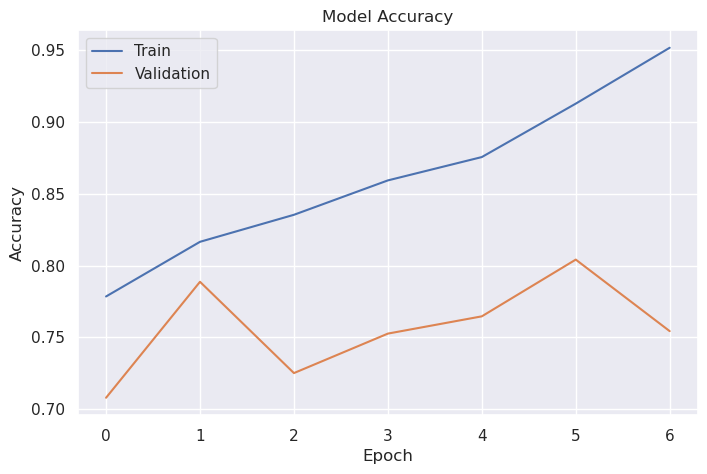

In [46]:
plt.figure(figsize=(8,5))

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [47]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 [==============================] - 12s 15ms/step


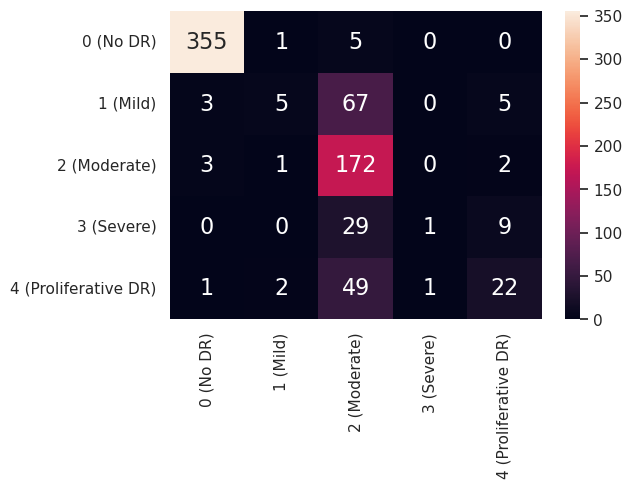

In [48]:
def create_confusion_matrix(actual,predictions,classes):
    cf = confusion_matrix(actual,predictions)
    cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(6,4))
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, annot_kws={'size':16},xticklabels=classes, yticklabels=classes, fmt='g')
    plt.show()

labels = ['0 (No DR)','1 (Mild)', '2 (Moderate)', '3 (Severe)', '4 (Proliferative DR)']
create_confusion_matrix(df_train_test['diagnosis'].astype(int), test_labels, labels)